In [59]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# read in csv
ed_df = pd.read_csv("source/ED 2020.csv")
inpt_df = pd.read_csv("source/2020 INPATIENT.csv")

C:\Users\grgil\AppData\Local\Temp\ipykernel_1876\1900474254.py:6: DtypeWarning: Columns (23,29,80) have mixed types. Specify dtype option on import or set low_memory=False.
  ed_df = pd.read_csv("source/ED 2020.csv")
C:\Users\grgil\AppData\Local\Temp\ipykernel_1876\1900474254.py:7: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  inpt_df = pd.read_csv("source/2020 INPATIENT.csv")


In [60]:
# define cols with diagnosis codes
othdiag = [col for col in ed_df.columns if 'OTHDIAG' in col]
ed_diag_cols = ['REASON_CDE', 'PRINDIAG'] + othdiag

othdiag = [col for col in inpt_df.columns if 'OTHDIAG' in col]
inpt_diag_cols = ['ADMITDIAG', 'PRINDIAG'] + othdiag

# define regex patterns
adrd_pattern = r'^F0[12]\.(?:5[01]|8[01]).*'
sdoh_pattern = r"^Z(?:5[5-9]|6[0-5])(?:\.\d+)?$"

# define cols to keep
ed_keep_cols = ["SEX", "AGE", "LOSDAYS", "HR_ARRIVAL", "PT_STATUS", "PAYER", "WEEKDAY"] + ed_diag_cols
inpt_keep_cols = ["SEX", "AGE", "LOSDAYS", "EDHR_ARR", "DISCHSTAT", "PAYER", "WEEKDAY", "ADM_TIME" ] + inpt_diag_cols

# filter dataframes
ed_filtered = ed_df[
    ed_df[ed_diag_cols].apply(lambda x: x.str.contains(adrd_pattern, na=False, regex=True)).any(axis=1) &
    ed_df[ed_diag_cols].apply(lambda x: x.str.contains(sdoh_pattern, na=False, regex=True)).any(axis=1)
][ed_keep_cols]

inpt_filtered = inpt_df[
    inpt_df[inpt_diag_cols].apply(lambda x: x.str.contains(adrd_pattern, na=False, regex=True)).any(axis=1) &
    inpt_df[inpt_diag_cols].apply(lambda x: x.str.contains(sdoh_pattern, na=False, regex=True)).any(axis=1)
][inpt_keep_cols]

In [61]:
def extract_all_z_codes(row, diag_cols):
    z_codes = []
    for col in diag_cols:
        if pd.notna(row[col]):
            matches = pd.Series(str(row[col])).str.findall(r'Z5[5-9]|Z6[0-5]')
            if len(matches) > 0:
                z_codes.extend(matches.iloc[0])
    return z_codes

# extract all Z-codes for each encounter, store as list
ed_z = ed_filtered.apply(lambda row: extract_all_z_codes(row, ed_diag_cols), axis=1)
inpt_z = inpt_filtered.apply(lambda row: extract_all_z_codes(row, inpt_diag_cols), axis=1)

# flatten lists and count all occurrences
ed_counts = pd.Series([code for codes in ed_z for code in codes]).value_counts()
inpt_counts = pd.Series([code for codes in inpt_z for code in codes]).value_counts()

# list of z code categories
z_cat = ['Education/Literacy', 'Employment', 'Occupational Exposure', 'Housing/Economic', 'Social Environment',
         'Upbringing', 'Family/Household', 'Other Psychosocial']

# combined summary table
z_code_summary = pd.DataFrame({
    'Z Code Category' : z_cat,
    'ED Count': ed_counts,
    'ED %': (ed_counts / ed_counts.sum() * 100).round(1),
    'Inpatient Count': inpt_counts,
    'Inpatient %': (inpt_counts / inpt_counts.sum() * 100).round(1)
}).fillna(0)

# format pct and total counts
z_code_summary['Total Count'] = (z_code_summary['ED Count'] + z_code_summary['Inpatient Count']).astype(int)
z_code_summary['Total %'] = (z_code_summary['Total Count'] / z_code_summary['Total Count'].sum() * 100).round(1)
z_code_summary[['ED Count', 'Inpatient Count']] = z_code_summary[['ED Count', 'Inpatient Count']].astype(int)

# export to csv
z_code_summary.to_csv('z_code_summary.csv')

In [62]:
# standardize ED discharge status col
ed_filtered = ed_filtered.rename(columns={'PT_STATUS': 'DISCHSTAT'})

# list of categorical variables
cat_vars = ['SEX', 'PAYER', 'DISCHSTAT']

# create list to store results
all_rows = []

for var in cat_vars:

    # calc counts
    ed_counts = ed_filtered[var].value_counts() if var in ed_filtered.columns else pd.Series(dtype=int)
    ip_counts = inpt_filtered[var].value_counts() if var in inpt_filtered.columns else pd.Series(dtype=int)
    
    # calc pct
    ed_pct = (ed_counts / ed_counts.sum() * 100) if len(ed_counts) > 0 else pd.Series(dtype=float)
    ip_pct = (ip_counts / ip_counts.sum() * 100) if len(ip_counts) > 0 else pd.Series(dtype=float)
    
    #combine values
    combined = pd.DataFrame({
        'ED Count': ed_counts,
        'ED %': ed_pct,
        'Inpatient Count': ip_counts,
        'Inpatient %': ip_pct
    }).fillna(0)
    
    # calc totals
    combined['Total Count'] = combined['ED Count'] + combined['Inpatient Count']
    combined['Total %'] = (combined['Total Count'] / combined['Total Count'].sum() * 100)

    # format pct and total counts
    combined[['ED %', 'Inpatient %', 'Total %']] = combined[['ED %', 'Inpatient %', 'Total %']].round(1)
    combined[['ED Count', 'Inpatient Count', 'Total Count']] = combined[['ED Count', 'Inpatient Count', 'Total Count']].astype(int)
    
    # add var name and category
    combined.insert(0, 'Variable', var)
    combined.insert(1, 'Category', combined.index)
    
    # append list
    all_rows.append(combined.reset_index(drop=True))

# concat list to df
demos_df = pd.concat(all_rows, ignore_index=True)

# export to csv
demos_df.to_csv("demographic_summary.csv", index=False)

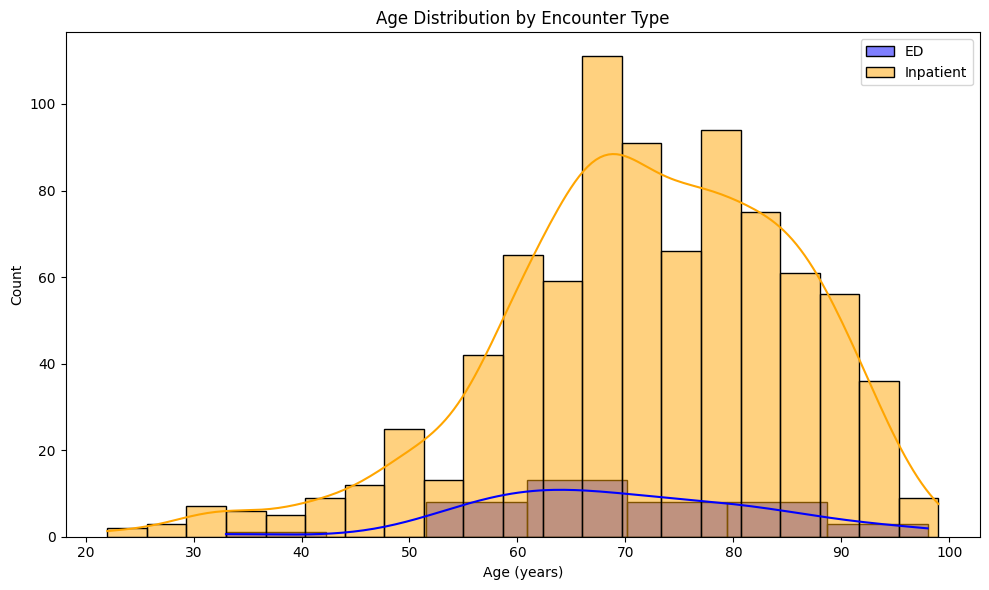

In [ ]:
# exclude out of range age (100+)
inpt_plot = inpt_filtered[inpt_filtered['AGE'] != 888]

# create plot object
fig, ax = plt.subplots(figsize=(10, 6))

# create histogram with density curves
sns.histplot(data=ed_filtered, x='AGE', kde=True, label='ED', alpha=0.5, color='blue', ax=ax)
sns.histplot(data=inpt_plot, x='AGE', kde=True, label='Inpatient', alpha=0.5, color='orange', ax=ax)

ax.set_xlabel('Age (years)')
ax.set_ylabel('Count')
ax.set_title('Age Distribution by Encounter Type')
ax.legend()
plt.tight_layout()
plt.savefig('age_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

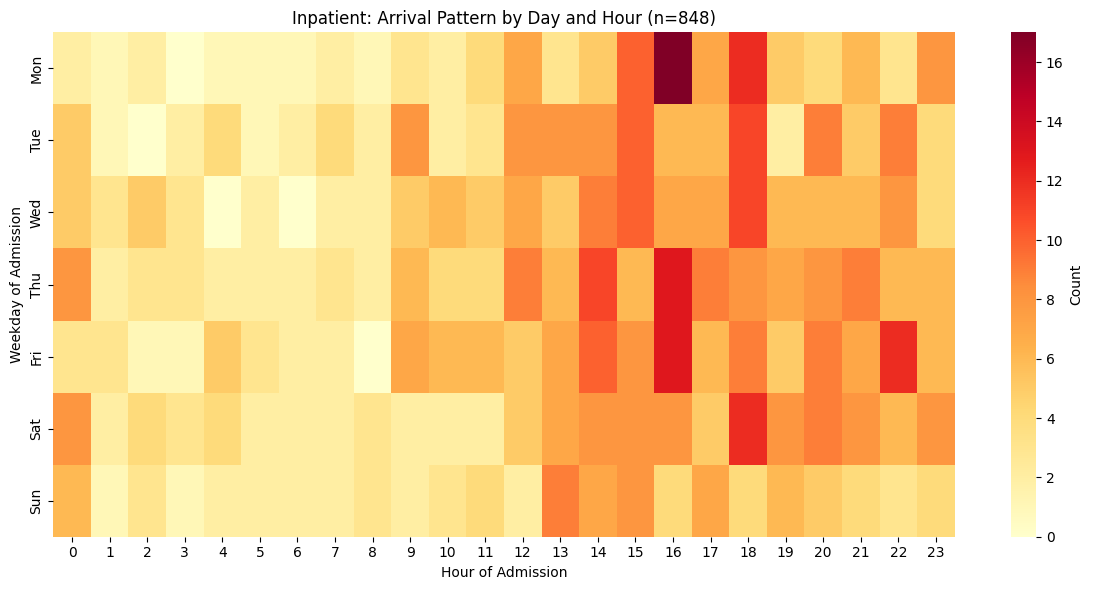

In [64]:
# exclude encounters with admit time unknown
inpt_plot = inpt_filtered[inpt_filtered['ADM_TIME'] != 99]

# inpatient heatmap data only
inpt_heatmap_data = inpt_plot.groupby(['WEEKDAY', 'ADM_TIME']).size().unstack(fill_value=0)

# map day numbers to names for clarity
day_mapping = {1: 'Mon', 2: 'Tue', 3: 'Wed', 4: 'Thu', 5: 'Fri', 6: 'Sat', 7: 'Sun'}
inpt_heatmap_data = inpt_heatmap_data.rename(index=day_mapping)

# create heatmap plot
fig, ax = plt.subplots(figsize=(12, 6))
sns.heatmap(inpt_heatmap_data, cmap='YlOrRd', annot=False, cbar_kws={'label': 'Count'}, ax=ax)
ax.set_xlabel('Hour of Admission')
ax.set_ylabel('Weekday of Admission')
ax.set_title('Inpatient: Arrival Pattern by Day and Hour (n=848)')
plt.tight_layout()
plt.savefig('arrival_patterns.png', dpi=300, bbox_inches='tight')
plt.show()